<a href="https://colab.research.google.com/github/diejo57/Quant-Analysis/blob/main/sentiment_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:

!pip install yfinance textblob snscrape matplotlib pandas --quiet

In [18]:
# Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

In [19]:

# Download daily stock data for Tesla (2023)
stock = yf.download("TSLA", start="2023-01-01", end="2023-12-31")

# If Yahoo returns MultiIndex columns, flatten them
if isinstance(stock.columns, pd.MultiIndex):
    stock.columns = ['_'.join([str(c) for c in col if c]) for col in stock.columns.values]

# Reset index so "Date" becomes a column
stock = stock.reset_index()

# Make sure "Date" is timezone-naive
stock['Date'] = pd.to_datetime(stock['Date']).dt.tz_localize(None)

# Detect the Close column automatically (can vary depending on download)
close_col = [c for c in stock.columns if 'Close' in c][0]

# Calculate daily returns
stock['Return'] = stock[close_col].pct_change()

print("Stock data preview:")
print(stock.head())


/tmp/ipython-input-697085221.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download("TSLA", start="2023-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Stock data preview:
        Date  Close_TSLA   High_TSLA    Low_TSLA   Open_TSLA  Volume_TSLA  \
0 2023-01-03  108.099998  118.800003  104.639999  118.470001    231402800   
1 2023-01-04  113.639999  114.589996  107.519997  109.110001    180389000   
2 2023-01-05  110.339996  111.750000  107.160004  110.510002    157986300   
3 2023-01-06  113.059998  114.389999  101.809998  103.000000    220911100   
4 2023-01-09  119.769997  123.519997  117.110001  118.959999    190284000   

     Return  
0       NaN  
1  0.051249  
2 -0.029039  
3  0.024651  
4  0.059349  


In [20]:
# Load CSV file of Musk's tweets (adjust path if needed)
tweets = pd.read_csv("/elon_musk_tweets.csv", encoding="utf-8")

# Keep only relevant columns
tweets = tweets[['date', 'text']].copy()

# Convert to datetime, drop timezone info
tweets['date'] = pd.to_datetime(tweets['date']).dt.tz_localize(None)

print("\nTweets preview:")
print(tweets.head())


Tweets preview:
                 date                                               text
0 2022-07-05 17:55:09  @BillyM2k I find the gold toe sock – inevitabl...
1 2022-07-05 17:47:42                 Sock Con, the conference for socks
2 2022-07-05 17:46:15  Always something new for the magazine cover an...
3 2022-07-05 17:40:05                   @ExplainThisBob This guy gets it
4 2022-07-05 17:38:23  Sock tech is so advanced that you can get pret...


In [21]:
# Function to calculate sentiment polarity with TextBlob
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Apply sentiment scoring
tweets['sentiment'] = tweets['text'].apply(get_sentiment)

print("\nSentiment preview:")
print(tweets[['date', 'text', 'sentiment']].head())


Sentiment preview:
                 date                                               text  \
0 2022-07-05 17:55:09  @BillyM2k I find the gold toe sock – inevitabl...   
1 2022-07-05 17:47:42                 Sock Con, the conference for socks   
2 2022-07-05 17:46:15  Always something new for the magazine cover an...   
3 2022-07-05 17:40:05                   @ExplainThisBob This guy gets it   
4 2022-07-05 17:38:23  Sock tech is so advanced that you can get pret...   

   sentiment  
0  -0.093750  
1   0.000000  
2   0.136364  
3   0.000000  
4   0.300000  


In [22]:
# Convert timestamp to just the date
tweets['day'] = tweets['date'].dt.date

# Average sentiment per day
daily_sentiment = tweets.groupby('day')['sentiment'].mean().reset_index()

# Convert back to datetime for merging
daily_sentiment['day'] = pd.to_datetime(daily_sentiment['day'])

print("\nDaily sentiment preview:")
print(daily_sentiment.head())


Daily sentiment preview:
         day  sentiment
0 2022-07-05   0.150476
1 2022-07-06   0.121172
2 2022-07-07   0.218190
3 2022-07-08   0.006737
4 2022-07-11  -0.005000


In [23]:

# Merge on date
data = pd.merge(stock, daily_sentiment, left_on='Date', right_on='day', how='left')

# Drop duplicate column
data = data.drop(columns=['day'])

print("\nMerged data preview:")
print(data.head())


Merged data preview:
        Date  Close_TSLA   High_TSLA    Low_TSLA   Open_TSLA  Volume_TSLA  \
0 2023-01-03  108.099998  118.800003  104.639999  118.470001    231402800   
1 2023-01-04  113.639999  114.589996  107.519997  109.110001    180389000   
2 2023-01-05  110.339996  111.750000  107.160004  110.510002    157986300   
3 2023-01-06  113.059998  114.389999  101.809998  103.000000    220911100   
4 2023-01-09  119.769997  123.519997  117.110001  118.959999    190284000   

     Return  sentiment  
0       NaN   0.021181  
1  0.051249   0.192857  
2 -0.029039   0.119423  
3  0.024651   0.028571  
4  0.059349   0.135190  


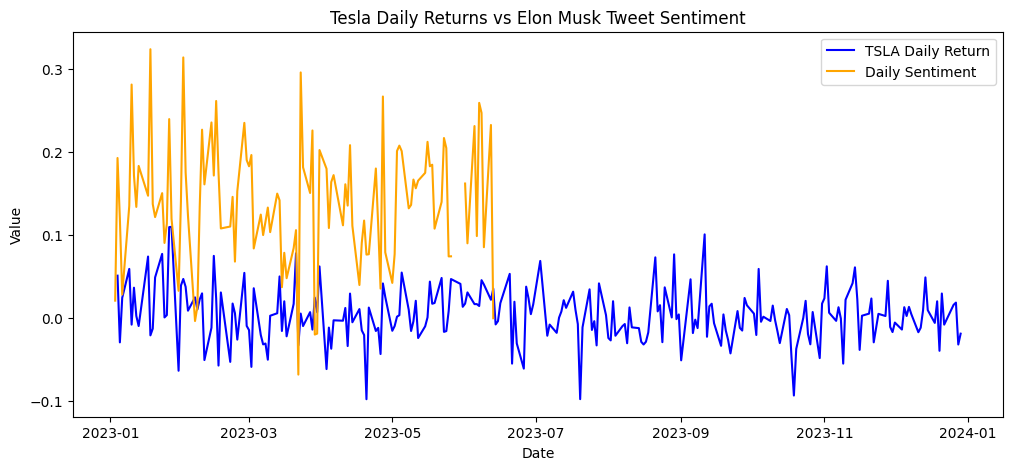

In [24]:
plt.figure(figsize=(12,5))
plt.plot(data['Date'], data['Return'], label='TSLA Daily Return', color='blue')
plt.plot(data['Date'], data['sentiment'], label='Daily Sentiment', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Tesla Daily Returns vs Elon Musk Tweet Sentiment')
plt.legend()
plt.show()

In [25]:
correlation = data[['Return', 'sentiment']].corr().iloc[0,1]

print(f"\n📊 Correlation between Tesla Returns and Musk's Daily Sentiment: {correlation:.4f}")


📊 Correlation between Tesla Returns and Musk's Daily Sentiment: 0.1383


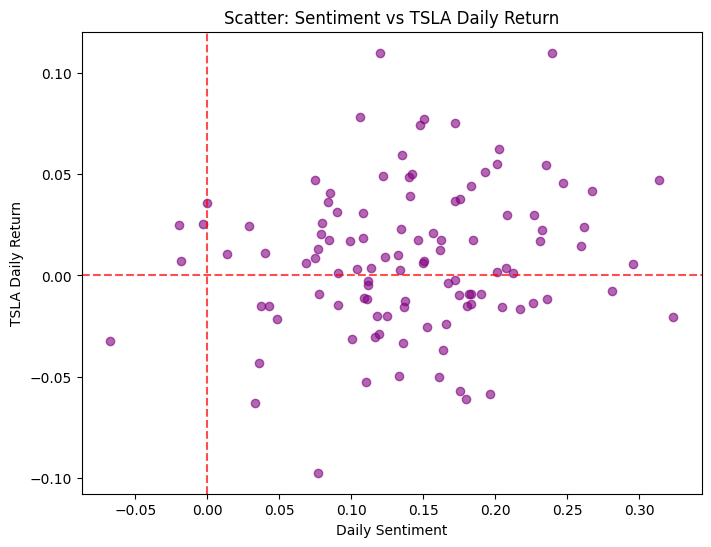

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(data['sentiment'], data['Return'], alpha=0.6, color='purple')
plt.xlabel("Daily Sentiment")
plt.ylabel("TSLA Daily Return")
plt.title("Scatter: Sentiment vs TSLA Daily Return")
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', alpha=0.7)
plt.show()


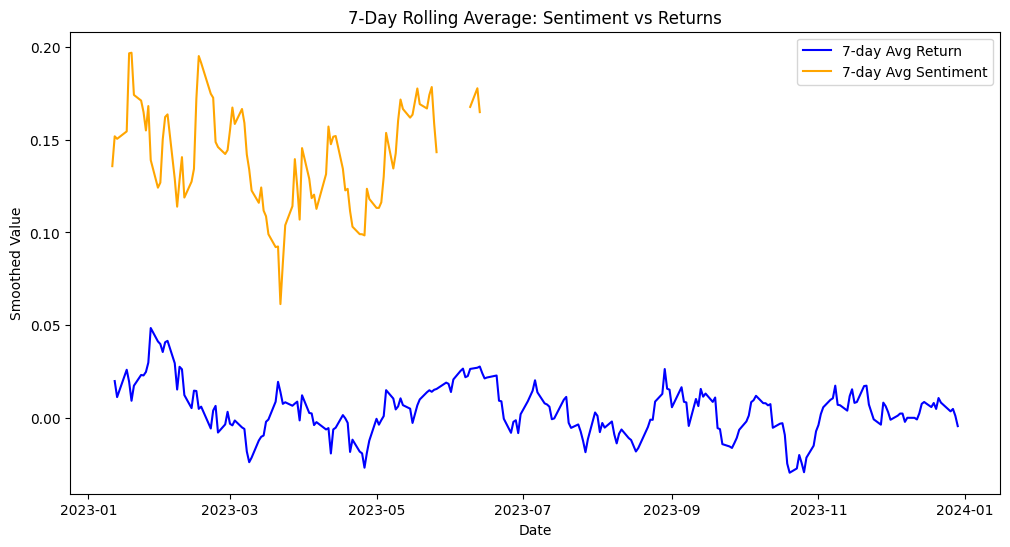

In [27]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Return'].rolling(7).mean(), label='7-day Avg Return', color='blue')
plt.plot(data['Date'], data['sentiment'].rolling(7).mean(), label='7-day Avg Sentiment', color='orange')
plt.xlabel("Date")
plt.ylabel("Smoothed Value")
plt.title("7-Day Rolling Average: Sentiment vs Returns")
plt.legend()
plt.show()


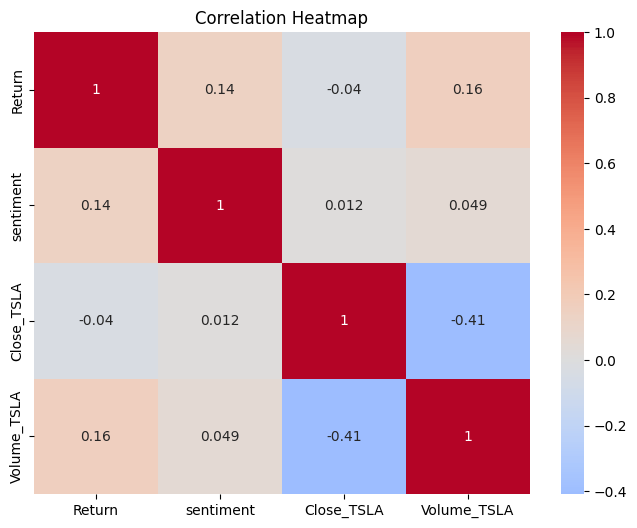

In [28]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(data[['Return','sentiment','Close_TSLA','Volume_TSLA']].corr(),
            annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


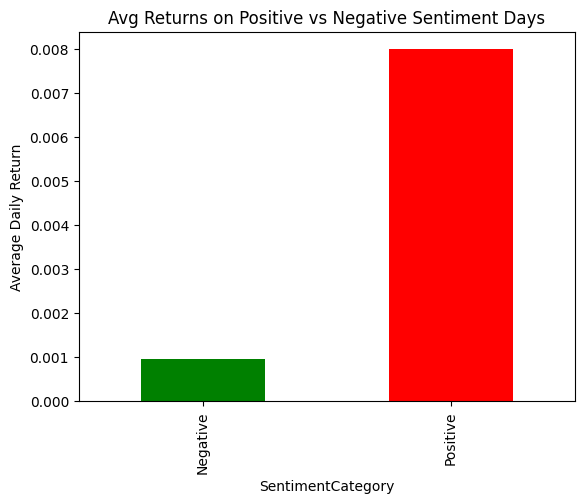

In [29]:
data['SentimentCategory'] = data['sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

avg_returns = data.groupby('SentimentCategory')['Return'].mean()

avg_returns.plot(kind='bar', color=['green','red'])
plt.ylabel("Average Daily Return")
plt.title("Avg Returns on Positive vs Negative Sentiment Days")
plt.show()


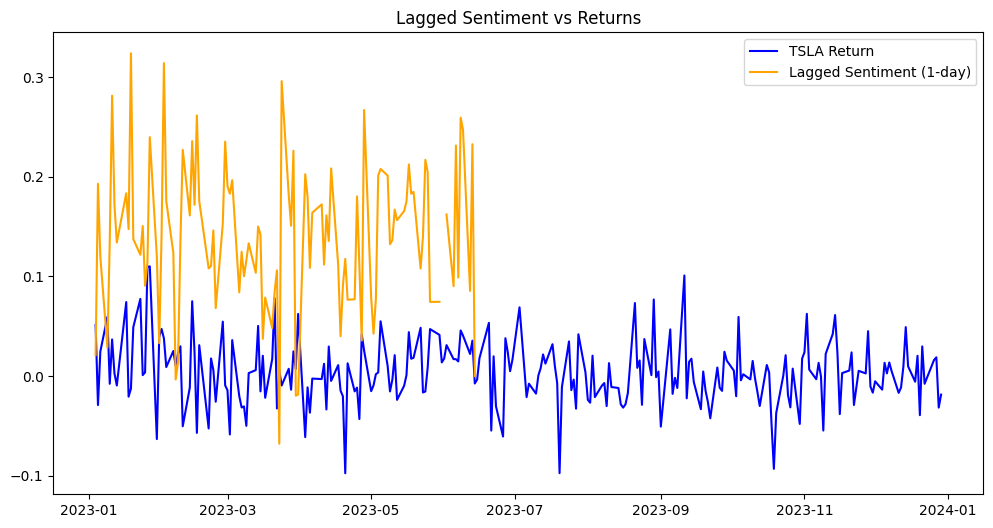

In [30]:
data['LaggedSentiment'] = data['sentiment'].shift(1)

plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Return'], label="TSLA Return", color="blue")
plt.plot(data['Date'], data['LaggedSentiment'], label="Lagged Sentiment (1-day)", color="orange")
plt.legend()
plt.title("Lagged Sentiment vs Returns")
plt.show()
